**DIP Project : Identifying Brain tumor using Brain MRI images**

In [ ]:
#Importing the required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import tensorflow as tf

In [ ]:
#Accessing google drive, where the MRI images are stored
#For now, there are 19 images in the drive, 9 without tumor and 10 with tumor
drive.mount('/content/drive')
image_path = "drive/My Drive/MRI_Dataset"
image_files = sorted([os.path.join(image_path, file)
                          for file in os.listdir(image_path)
                          if file.endswith('.jpg')])

Mounted at /content/drive


So far, we have read our input MRI images into an array, so that they can be worked on easily. The entire MRI dataset available on Kaggle consisted of a total of 98 images without tumors, and 155 images with tumors. All the images were greyscale, however they were'nt of the same size.

As uploading the entire dataset and working on all of the images was neither necessary nor feasibile, we work with just 19 images, which include 10 images containing tumors, and 9 that don't. These images were chosen randomly from the dataset. 

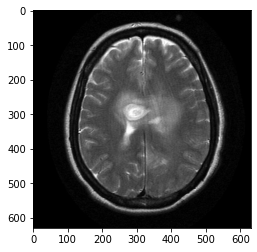

In [ ]:
#Reading the images into an array img, and plotting an image to check it works
img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in image_files[:]]   
plt.imshow(img[-1])

**IMAGE DENOISING**

The first step in our image processing task is removing noise from the images. We have tried three noise removal techniques, and compared the final denoised images by their PSNR values to figure out which technique would work best. The denoising techniques were as follows:

**1) Gaussian Blur:**

Gaussian Blur involves passing the image through a Gaussian Low Pass Filter. It is a smoothing operator that blurs images and removes details and Noise. In a sense, the Gaussian LPF is similar to a Mean Filter, but the kernel is different, and represented in the form of a Bell-Shaped hump.

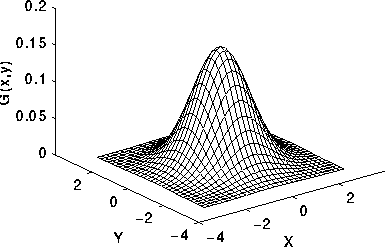

**2) Median Filtering:**

Median Filtering is a non-Linear image filtering technique, used to remove noise from an image. Its biggest advantage is that it removes noise while also preserving edges to some extent. It works by computing the median of the neighbors for each pixel in the image, and replacing it's value with the median.

**3) Non Local Means Denoising:**

Non Local Means Denoising is another strong noise-removal technique. It involves taking a pixel, then taking a small window around it. We then search for similar windows within the input image, and average out all such windows and then replace the pixel with the result we got. This method is computationally a bit expensive, but it gives good results.

In [ ]:
Denoised_Gaussian = []
Denoised_Median = []
Denoised_Nlmean = []  
for i in range(len(img)):
  temp1 = cv2.GaussianBlur(img[i], (5, 5), 0)   #Applying Gaussian Blur to remove noise
  Denoised_Gaussian.append(temp1)
  temp2 = cv2.medianBlur(img[i],5)    #Applying Median filter to remove noise
  Denoised_Median.append(temp2)
  temp3 = cv2.fastNlMeansDenoising(img[i],10,10,7,21)
  Denoised_Nlmean.append(temp3)     #Applying Non-Local Means Denoising.


(<matplotlib.image.AxesImage at 0x7efbd9a33048>,
 Text(0.5, 1.0, 'Image after Non-Local Means Denoising'))

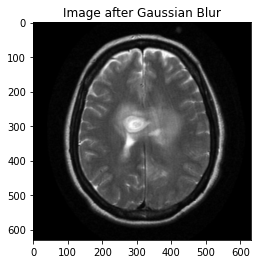

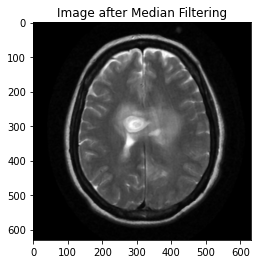

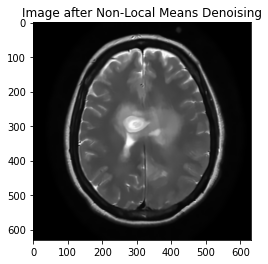

In [ ]:
plt.figure(1)
plt.imshow(Denoised_Gaussian[-1]), plt.title("Image after Gaussian Blur")
plt.figure(2)
plt.imshow(Denoised_Median[-1]), plt.title("Image after Median Filtering")
plt.figure(3)
plt.imshow(Denoised_Nlmean[-1]), plt.title("Image after Non-Local Means Denoising")


We then compute the PSNR values of the denoised images by each of the techniques with respect to the original imput images. This step is carried out to figure out which noise removal technique works the best, since visual analysis of the images isn't enough.

In [ ]:
psnr_gauss = cv2.PSNR(Denoised_Gaussian[-1],img[-1],255)
print("PSNR for Gaussian = ",psnr_gauss)
psnr_median = cv2.PSNR(Denoised_Median[-1],img[-1],255)
print("PSNR for Median = ",psnr_median)
psnr_nlmean = cv2.PSNR(Denoised_Nlmean[-1],img[-1],255)
print("PSNR for NL Means = ",psnr_nlmean)
if psnr_gauss == max(psnr_gauss,psnr_median,psnr_nlmean):
  print("Max PSNR value is obtained after Gaussian Blurring")
elif psnr_median == max(psnr_gauss,psnr_median,psnr_nlmean):
  print("Max PSNR value is obtained after Median Blurring")
else:
  print("Max PSNR value is obtained after Non-Local Means Denoising")


PSNR for Gaussian =  39.01851063376625
PSNR for Median =  36.40802948630205
PSNR for NL Means =  36.64395181388968
Max PSNR value is obtained after Gaussian Blurring


**IMAGE SHARPENING**

Removing noise from images almost always causes blurring, and could lead to the loss of important features and edges. Hence, image sharpening procedures are carried out to highlight such edges. We tried a couple of image sharpening techniques, namely Laplacian Mask, and Unsharp Masking.

**1) Laplacian Mask:**

As we know, the gradient operator is often used to detect sudden changes in pixel values in the image, that is, detecting sharp edges. The Laplacian Mask works in the same way, by calculating the Laplacian of an image to isolate edges, and then adding the resultant image to the original image.

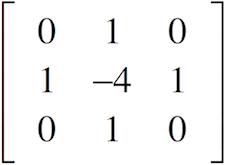

**2) Unsharp Mask:**

Unsharp Masking is an image sharpening technique, that uses a blurred, or "unsharp" of an image as a mask. This unsharp mask is combined with the original image, hence creating an image that is less blurry than the original. We used Gaussian Blur to creat the unsharp mask for the image, and used weighted addition to obtain our final sharpened image.

In [ ]:
Laplacian = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])

Sharp_Laplacian = []
Sharp_Unsharp = []
for i in range(len(Denoised_Gaussian)):
  image_sharp1 = cv2.filter2D(Denoised_Gaussian[i], -1, Laplacian)
  Sharp_Laplacian.append(image_sharp1)
  temp = cv2.GaussianBlur(Denoised_Gaussian[i], (5, 5), 0)
  image_sharp2 = cv2.addWeighted(Denoised_Gaussian[i], 1.5, temp , -0.5, 0, Denoised_Gaussian[i])
  Sharp_Unsharp.append(image_sharp2)


(<matplotlib.image.AxesImage at 0x7efbd98db358>,
 Text(0.5, 1.0, 'Image after Sharpening with Unsharp Mask'))

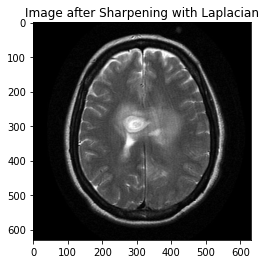

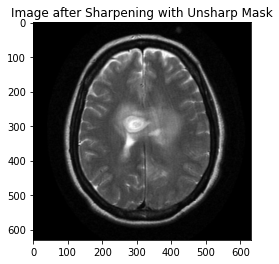

In [ ]:
plt.figure(1)
plt.imshow(Sharp_Laplacian[-1]), plt.title("Image after Sharpening with Laplacian")
plt.figure(2)
plt.imshow(Sharp_Unsharp[-1]), plt.title("Image after Sharpening with Unsharp Mask")


# **Segmentation** 

Segmentation is the technique of dividing or partitioning an image into parts, called segments. It is mostly useful for applications like image compression or object recognition. Here we are using Threshold and Adaptive Threshold Segmentation. Another method of segmentation is Watershed Segmentation.


**1. Threshold Method**

In case of threshold, we change the pixels of an image to make the image easier to analyze, where there is a convertion of an image from color or grayscale into a binary image (Black and white).

**2. Watershed Method**

Watersheds separate basins from each other. It basically sperates and assigns all the pixels into either a region or a watershed area. 




In [ ]:
thresh_seg = []
adThresh_seg = []


  #Threshold Method
for i in range(len(Sharp_Laplacian)):
  image = Sharp_Laplacian[i]
  #shifted = cv2.pyrMeanShiftFiltering(image, 5, 35)
  #gray = cv2.cvtColor(shifted.astype(np.uint8), cv2.COLOR_BGR2GRAY)
  if image.ndim == 2:
    grey = image
  elif image.ndim == 3:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
  addap_thresh = cv2.adaptiveThreshold(gray, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11,-2)
  thresh_seg.append(thresh)
  adThresh_seg.append(addap_thresh)
#workingg.. 


(<matplotlib.image.AxesImage at 0x7f878f03fcc0>,
 Text(0.5, 1.0, 'Image after Segmentaion using ADThreshold'))

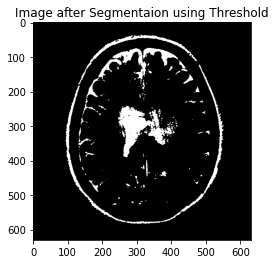

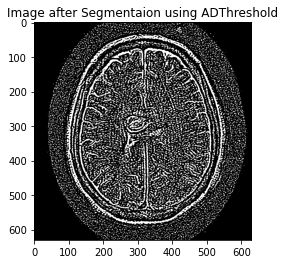

In [ ]:
plt.figure(1)
plt.imshow(thresh_seg[-1], cmap= 'gray', vmin=0, vmax=250), plt.title("Image after Segmentaion using Threshold")
plt.figure(2)
plt.imshow(adThresh_seg[-1], cmap= 'gray', vmin=0, vmax=250), plt.title("Image after Segmentaion using ADThreshold")
#plt.figure(3)
#plt.imshow(waters_seg[-1], cmap= 'gray', vmin=0, vmax=250), plt.title("Image after Segmentaion using Watershed Method")

In [ ]:
kernel = np.ones((3, 3), np.uint8)
Morph = []
for i in range(len(thresh_seg)):
  opening = cv2.morphologyEx(thresh_seg[i], cv2.MORPH_OPEN, kernel, iterations=7)
  sure_bg = cv2.dilate(opening, kernel, iterations=3)
  dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
  ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
  sure_fg = np.uint8(sure_fg)
  Morph.append(sure_bg)



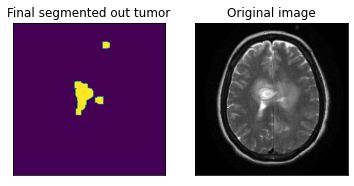

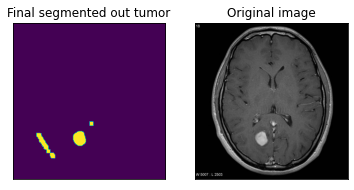

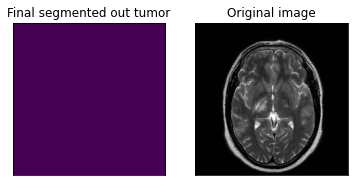

In [ ]:
plt.figure(1)
plt.subplot(121), plt.imshow(Morph[-1]), plt.title("Final segmented out tumor")
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img[-1]), plt.title("Original image")
plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(2)
plt.subplot(121), plt.imshow(Morph[15]), plt.title("Final segmented out tumor")
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img[15]), plt.title("Original image")
plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(3)
plt.subplot(121), plt.imshow(Morph[5]), plt.title("Final segmented out tumor")
plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img[5]), plt.title("Original image")
plt.xticks([]), plt.yticks([])
plt.show()